<a href="https://colab.research.google.com/github/AhmadMugiar/WEB_SCRAPPING_KP/blob/main/Analisis_Sentimen_Aplikasi_PosAgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gdown
!pip install Sastrawi
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import re
import string
import requests
from io import StringIO
import gdown
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
data = pd.read_csv('/content/Scrapping_Clean_PosAgen.csv')
data

,reviewId,userName,rate,reviews_text,tanggal reviews
0,0dc7e3ea-0feb-49bc-9300-7e7e056e0bdf,helga alvian,5,aplikasi pembayaran terbaik,2025-08-06
1,d0ea4d13-30e8-493e-ab09-5d49dd09564d,hardju adam,5,ok,2025-07-20
2,89eb0450-f6bd-442b-9b08-cbbc159dd091,sutarji,5,memudah kan informasi cepat tepat kepada masya...,2025-07-20
3,a34d79dc-c7d2-4f11-b2c8-c4066dde311d,kristofel ola,5,bagus,2025-07-16
4,61b6d77f-1ec5-4ed1-a2dd-e59cb5f70d43,yayan heryana,5,sangat membantu,2025-07-13
...,...,...,...,...,...
1561,eacbc656-764a-4ac5-baa7-3d790933008b,pengguna google,5,semoga bisa bersaing dengan fintech lainnya,2019-03-01
1562,a14ce4af-0473-422d-8dca-1e75168544e8,pengguna google,3,gimana cara verifikasinya? sedangkan gak bisa ...,2019-02-03
1563,cc513da8-7a0d-439f-abb1-f3ad0b135b71,pengguna google,4,semoga makin lama makin hebat,2019-01-22
1564,5602a965-e553-4db8-9d8b-815f1cb331e9,pengguna google,1,"parah, awas ada biaya tersembunyi 2000/isi sal...",2019-01-19


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewId         1566 non-null   object
 1   userName         1566 non-null   object
 2   rate             1566 non-null   int64 
 3   reviews_text     1566 non-null   object
 4   tanggal reviews  1566 non-null   object
dtypes: int64(1), object(4)
memory usage: 61.3+ KB


In [8]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [9]:
def cleaningText(text):
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Hapus retweet
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus link
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)  # Hapus tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus tanda baca dan karakter selain huruf
    text = re.sub(r'(.)\1{1,}', r'\1', text)  # Menangani huruf berulang
    text = re.sub(r'\n', ' ', text)  # Ganti newline dengan spasi
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih
    return text

In [10]:
def casefoldingText(text):
    return text.lower()

In [12]:
def load_slang_dictionary(filepath):
    slang_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if ':' in line:
                slang, baku = line.strip().split(':', 1)
                slang_dict[slang.strip()] = baku.strip()
    return slang_dict
slang_dict = load_slang_dictionary('slang.txt')

def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

In [13]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [14]:
# custom stopwords
custom_stopwords = set(stopwords.words('indonesian')).union({'yg', 'dgn', 'dll', 'nya', 'dr', 'spt', 'juga', 'dan', 'yang', 'aku', 'saya','untuk', 'dari', 'di', 'ke', 'nya', 'adalah', 'itu', 'ini', 'ada', 'karena', 'dapat', 'dengan', 'sebagai', 'dalam', 'pada', 'agar', 'lebih', 'kurang','tersebut', 'bahwa', 'mungkin', 'bisa', 'aplikasi', 'duolingo', 'apknya', 'aplikasinya', 'apk', 'belajar', 'sangat', 'sekali', 'jika', 'tidak', 'cuma', 'cuman', 'jadi', 'ya', 'aja', 'udah', 'kok', 'malah', 'tapi', 'loh', 'lah'})

In [15]:
def filteringText(words):
    return [word for word in words if word not in custom_stopwords]

In [16]:
def stemmingText(words):
    return [stemmer.stem(word) for word in words]

In [17]:
def toSentence(list_words):
    return ' '.join(list_words)

In [18]:
data['after_cleaning'] = data['reviews_text'].apply(cleaningText)

In [19]:
data[['reviews_text', 'after_cleaning']].head(10)

,reviews_text,after_cleaning
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik
1,ok,ok
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...
3,bagus,bagus
4,sangat membantu,sangat membantu
5,bagus,bagus
6,super,super
7,terimakasih,terimakasih
8,belom ada notif pembaruan,belom ada notif pembaruan
9,gak jelas,gak jelas


In [20]:
data['after_casefolding'] = data['after_cleaning'].apply(casefoldingText)

In [21]:
data[['reviews_text', 'after_cleaning', 'after_casefolding']].head(10)

,reviews_text,after_cleaning,after_casefolding
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik
1,ok,ok,ok
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...
3,bagus,bagus,bagus
4,sangat membantu,sangat membantu,sangat membantu
5,bagus,bagus,bagus
6,super,super,super
7,terimakasih,terimakasih,terimakasih
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan
9,gak jelas,gak jelas,gak jelas


In [22]:
data['after_normalized'] = data['after_casefolding'].apply(lambda x: normalize_slang(x, slang_dict))

In [23]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik
1,ok,ok,ok,oke
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah akan informasi cepat tepat kepada masy...
3,bagus,bagus,bagus,bagus
4,sangat membantu,sangat membantu,sangat membantu,sangat membantu
5,bagus,bagus,bagus,bagus
6,super,super,super,sangat
7,terimakasih,terimakasih,terimakasih,terima kasih
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan,belum ada notif pembaruan
9,gak jelas,gak jelas,gak jelas,tidak jelas


In [24]:
data['after_tokenizing'] = data['after_normalized'].apply(tokenizingText)

In [25]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,"[aplikasi, pembayaran, terbaik]"
1,ok,ok,ok,oke,[oke]
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah akan informasi cepat tepat kepada masy...,"[memudah, akan, informasi, cepat, tepat, kepad..."
3,bagus,bagus,bagus,bagus,[bagus]
4,sangat membantu,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]"
5,bagus,bagus,bagus,bagus,[bagus]
6,super,super,super,sangat,[sangat]
7,terimakasih,terimakasih,terimakasih,terima kasih,"[terima, kasih]"
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan,belum ada notif pembaruan,"[belum, ada, notif, pembaruan]"
9,gak jelas,gak jelas,gak jelas,tidak jelas,"[tidak, jelas]"


In [26]:
data['after_filtering'] = data['after_tokenizing'].apply(filteringText)

In [28]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,"[aplikasi, pembayaran, terbaik]","[pembayaran, terbaik]"
1,ok,ok,ok,oke,[oke],[oke]
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah akan informasi cepat tepat kepada masy...,"[memudah, akan, informasi, cepat, tepat, kepad...","[memudah, informasi, cepat, masyarakat]"
3,bagus,bagus,bagus,bagus,[bagus],[bagus]
4,sangat membantu,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu]
5,bagus,bagus,bagus,bagus,[bagus],[bagus]
6,super,super,super,sangat,[sangat],[]
7,terimakasih,terimakasih,terimakasih,terima kasih,"[terima, kasih]","[terima, kasih]"
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan,belum ada notif pembaruan,"[belum, ada, notif, pembaruan]","[notif, pembaruan]"
9,gak jelas,gak jelas,gak jelas,tidak jelas,"[tidak, jelas]",[]


In [29]:
data['after_stemming'] = data['after_filtering'].apply(stemmingText)

In [30]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering', 'after_stemming']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,"[aplikasi, pembayaran, terbaik]","[pembayaran, terbaik]","[bayar, baik]"
1,ok,ok,ok,oke,[oke],[oke],[oke]
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah akan informasi cepat tepat kepada masy...,"[memudah, akan, informasi, cepat, tepat, kepad...","[memudah, informasi, cepat, masyarakat]","[mudah, informasi, cepat, masyarakat]"
3,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus]
4,sangat membantu,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],[bantu]
5,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus]
6,super,super,super,sangat,[sangat],[],[]
7,terimakasih,terimakasih,terimakasih,terima kasih,"[terima, kasih]","[terima, kasih]","[terima, kasih]"
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan,belum ada notif pembaruan,"[belum, ada, notif, pembaruan]","[notif, pembaruan]","[notif, baru]"
9,gak jelas,gak jelas,gak jelas,tidak jelas,"[tidak, jelas]",[],[]


In [31]:
data['final_sentence'] = data['after_stemming'].apply(toSentence)

In [32]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering', 'after_stemming', 'final_sentence']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming,final_sentence
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,"[aplikasi, pembayaran, terbaik]","[pembayaran, terbaik]","[bayar, baik]",bayar baik
1,ok,ok,ok,oke,[oke],[oke],[oke],oke
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah akan informasi cepat tepat kepada masy...,"[memudah, akan, informasi, cepat, tepat, kepad...","[memudah, informasi, cepat, masyarakat]","[mudah, informasi, cepat, masyarakat]",mudah informasi cepat masyarakat
3,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus
4,sangat membantu,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],[bantu],bantu
5,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus
6,super,super,super,sangat,[sangat],[],[],
7,terimakasih,terimakasih,terimakasih,terima kasih,"[terima, kasih]","[terima, kasih]","[terima, kasih]",terima kasih
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan,belum ada notif pembaruan,"[belum, ada, notif, pembaruan]","[notif, pembaruan]","[notif, baru]",notif baru
9,gak jelas,gak jelas,gak jelas,tidak jelas,"[tidak, jelas]",[],[],


In [33]:
!gdown --id 1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ
To: /content/lexicon_positive_ver1.csv
100% 41.4k/41.4k [00:00<00:00, 73.7MB/s]


In [34]:
!gdown --id 1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju
To: /content/lexicon_negative_ver1.csv
100% 82.8k/82.8k [00:00<00:00, 62.5MB/s]


In [35]:
lexicon_positive = dict()
import csv
with open('lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [36]:
def sentimen_lexicon_indo(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score > 0):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'
  else:
    polarity = 'netral'

  return score, polarity

In [56]:
string = ""
string = string.split()
hasil = sentimen_lexicon_indo(string)
hasil

(-1, 'negatif')

In [40]:
data['tokenized'] = data['final_sentence'].apply(lambda x: x.split())

In [41]:
data[['score', 'sentiment']] = data['tokenized'].apply(lambda x: pd.Series(sentimen_lexicon_indo(x)))

In [42]:
results = data['tokenized'].apply(sentimen_lexicon_indo)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
print(data['polarity'].value_counts())

polarity
positif    732
negatif    635
netral     199
Name: count, dtype: int64


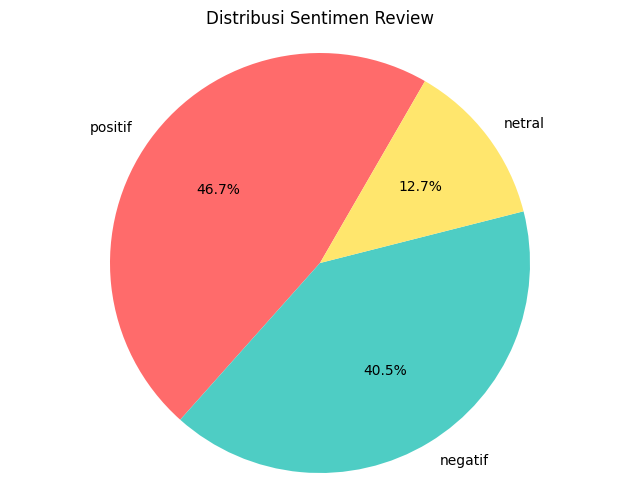

In [43]:
# Hitung jumlah masing-masing sentimen
sentiment_counts = data['polarity'].value_counts()

# Label dan nilai
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Buat pie chart
plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=60, colors=colors)
plt.title('Distribusi Sentimen Review')
plt.axis('equal')  # Membuat pie-nya jadi lingkaran sempurna
plt.show()

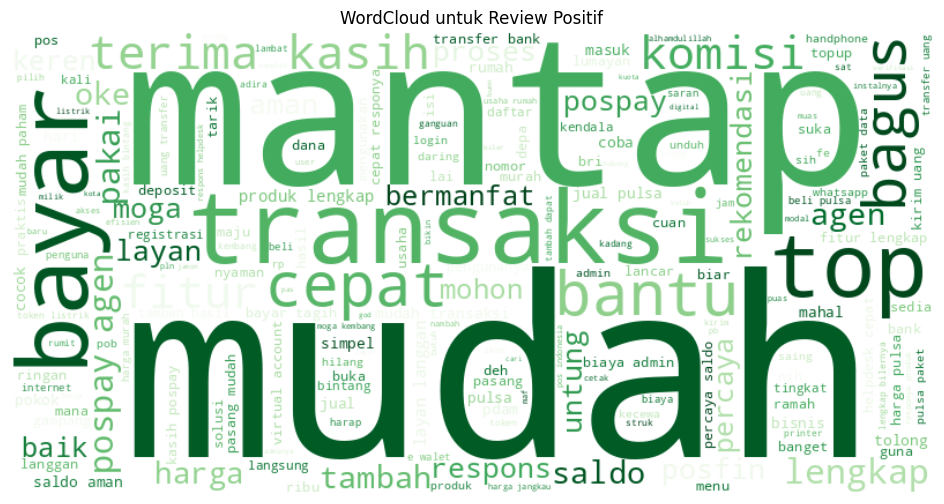

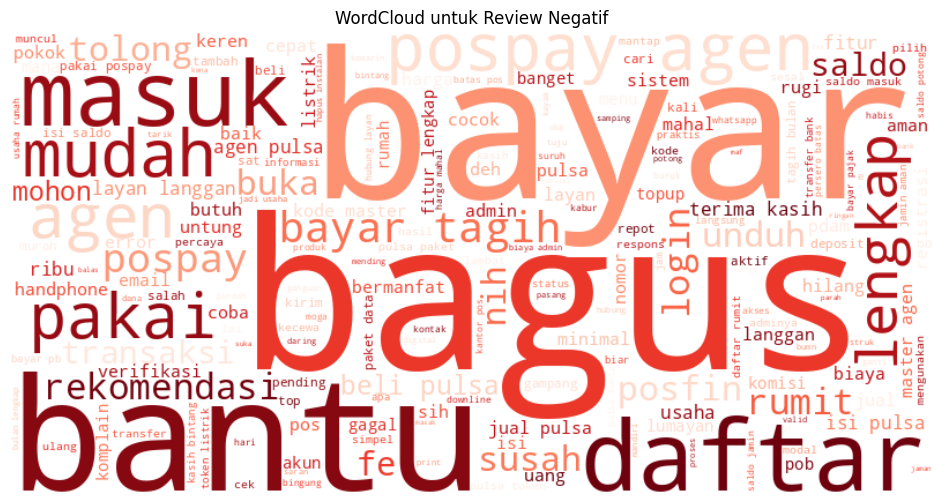

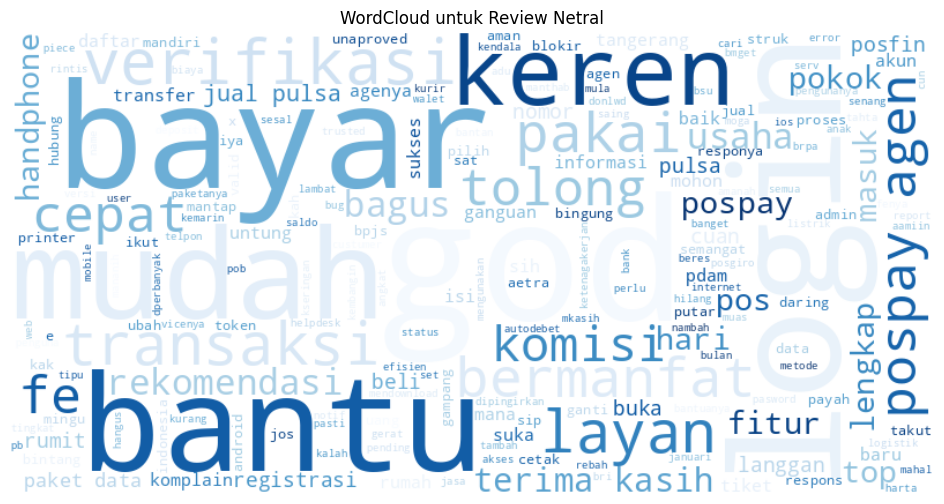

In [44]:
# Fungsi untuk membuat dan menampilkan WordCloud
def tampilkan_wordcloud(text, title, colormap):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Gabungkan semua teks dari tiap sentimen
positif_text = ' '.join(data[data['polarity'] == 'positif']['final_sentence'])
negatif_text = ' '.join(data[data['polarity'] == 'negatif']['final_sentence'])
netral_text  = ' '.join(data[data['polarity'] == 'netral']['final_sentence'])

# Tampilkan WordCloud
tampilkan_wordcloud(positif_text, 'WordCloud untuk Review Positif', 'Greens')
tampilkan_wordcloud(negatif_text, 'WordCloud untuk Review Negatif', 'Reds')
tampilkan_wordcloud(netral_text,  'WordCloud untuk Review Netral',  'Blues')

In [45]:
X = data['final_sentence']
y = data['polarity']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1252,)
(314,)


In [47]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [48]:
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

In [49]:
# Membuat objek model SVM
svm_model = SVC(C=1, kernel='rbf')

# Melatih model SVM pada data pelatihan
svm_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

# Evaluasi akurasi model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.9688498402555911
SVM - accuracy_test: 0.8630573248407644


In [50]:
# Menampilkan classification report
print('\nClassification Report SVM (Test Data):')
print(classification_report(y_test, y_pred_test_svm))


Classification Report SVM (Test Data):
              precision    recall  f1-score   support

     negatif       0.80      0.90      0.85       122
      netral       1.00      0.55      0.71        31
     positif       0.90      0.89      0.90       161

    accuracy                           0.86       314
   macro avg       0.90      0.78      0.82       314
weighted avg       0.87      0.86      0.86       314



In [57]:
# Membuat objek model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model Random Forest pada data pelatihan
rf_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = rf_model.predict(X_train.toarray())
y_pred_test_rf = rf_model.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 1.0
Random Forest - accuracy_test: 0.7993630573248408


In [58]:
# Menampilkan classification report
print('\nClassification Report Random Forest (Test Data):')
print(classification_report(y_test, y_pred_test_rf))


Classification Report Random Forest (Test Data):
              precision    recall  f1-score   support

     negatif       0.82      0.78      0.80       122
      netral       0.59      0.84      0.69        31
     positif       0.84      0.81      0.83       161

    accuracy                           0.80       314
   macro avg       0.75      0.81      0.77       314
weighted avg       0.81      0.80      0.80       314



In [59]:
X = data['final_sentence']
y = data['polarity']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1252,)
(314,)


In [61]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [62]:
# Label Encoding

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [63]:
# Custom Callback
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

In [64]:
# modeling dengan lstm
model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=32,
                        validation_data=(X_test_pad, y_test_cat), callbacks=[early_stop, reduce_lr])

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.4087 - loss: 1.0473 - val_accuracy: 0.5764 - val_loss: 0.9164 - learning_rate: 0.0010
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.5078 - loss: 0.9576 - val_accuracy: 0.7229 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.7275 - loss: 0.7222 - val_accuracy: 0.8376 - val_loss: 0.5095 - learning_rate: 0.0010
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.8546 - loss: 0.4349 - val_accuracy: 0.8535 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.9033 - loss: 0.2883 - val_accuracy: 0.8408 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.9541 - loss: 0.1808 - val_accuracy: 0.8312 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.9531 - loss: 0.1300 - val_

In [67]:
# Evaluasi akurasi pada data training
train_pred_probs = model.predict(X_train_pad)
train_pred = np.argmax(train_pred_probs, axis=1)
train_true = np.argmax(y_train_cat, axis=1)
accuracy_train_lstm = accuracy_score(train_true, train_pred)

# Evaluasi akurasi pada data testing
test_pred_probs = model.predict(X_test_pad)
test_pred = np.argmax(test_pred_probs, axis=1)
test_true = np.argmax(y_test_cat, axis=1)
accuracy_test_lstm = accuracy_score(test_true, test_pred)

# Menampilkan hasil evaluasi
print('LSTM - accuracy_train:', accuracy_train_lstm)
print('LSTM - accuracy_test:', accuracy_test_lstm)

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
LSTM - accuracy_train: 0.950479233226837
LSTM - accuracy_test: 0.8407643312101911


In [68]:
# Classification report
print("\nClassification Report Bidirectional LSTM (Test Data):")
print(classification_report(test_true, test_pred, target_names=encoder.classes_))


Classification Report Bidirectional LSTM (Test Data):
              precision    recall  f1-score   support

     negatif       0.83      0.85      0.84       122
      netral       0.71      0.77      0.74        31
     positif       0.88      0.84      0.86       161

    accuracy                           0.84       314
   macro avg       0.81      0.82      0.81       314
weighted avg       0.84      0.84      0.84       314

